# Introduction
Global temperatures have been rising since the turn of the century and this notebook is designed to analyse the dataset of global temperature values (taken from NASA GISS Surface Temperature Analysis (GISTEMP v4)) and conduct time-series forecasting using three methodologies - ARIMA, SARIMAX and LSTM.

# Data Preparation:
We are going to use a global mean temperature dataset(https://data.giss.nasa.gov/gistemp/tabledata_v4/GLB.Ts+dSST.csv) for this model and then check for any null values

In [49]:
#Import the right libraries and packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

In [50]:
#Loading and assigning the data to a dataframe
url = "https://data.giss.nasa.gov/gistemp/tabledata_v4/GLB.Ts+dSST.csv"
df_raw = pd.read_csv(url, skiprows=1)
df = df_raw.copy()

In [51]:
# Clean and prepare the data
# Remove missing values and set year as index
df = df.rename(columns=lambda x: x.strip())
df = df[['Year', 'J-D']]
df.columns = ['Year', 'Temperature Anomaly']
df = df[df['Temperature Anomaly'] != '***']
df['Temperature Anomaly'] = df['Temperature Anomaly'].astype(float)
df.set_index('Year', inplace=True)

# Analysis and Visualization:


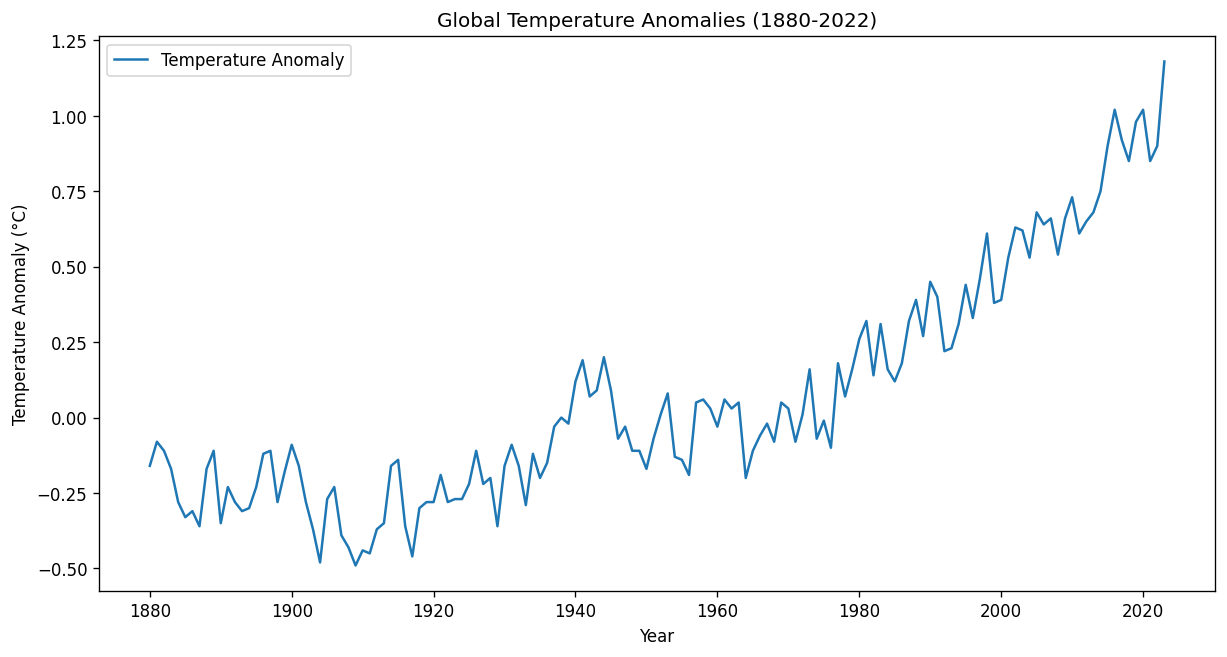

In [52]:
# Visualize the data
plt.figure(figsize=(12, 6))
plt.plot(df, label='Temperature Anomaly')
plt.title('Global Temperature Anomalies (1880-2022)')
plt.xlabel('Year')
plt.ylabel('Temperature Anomaly (°C)')
plt.legend()
plt.show()

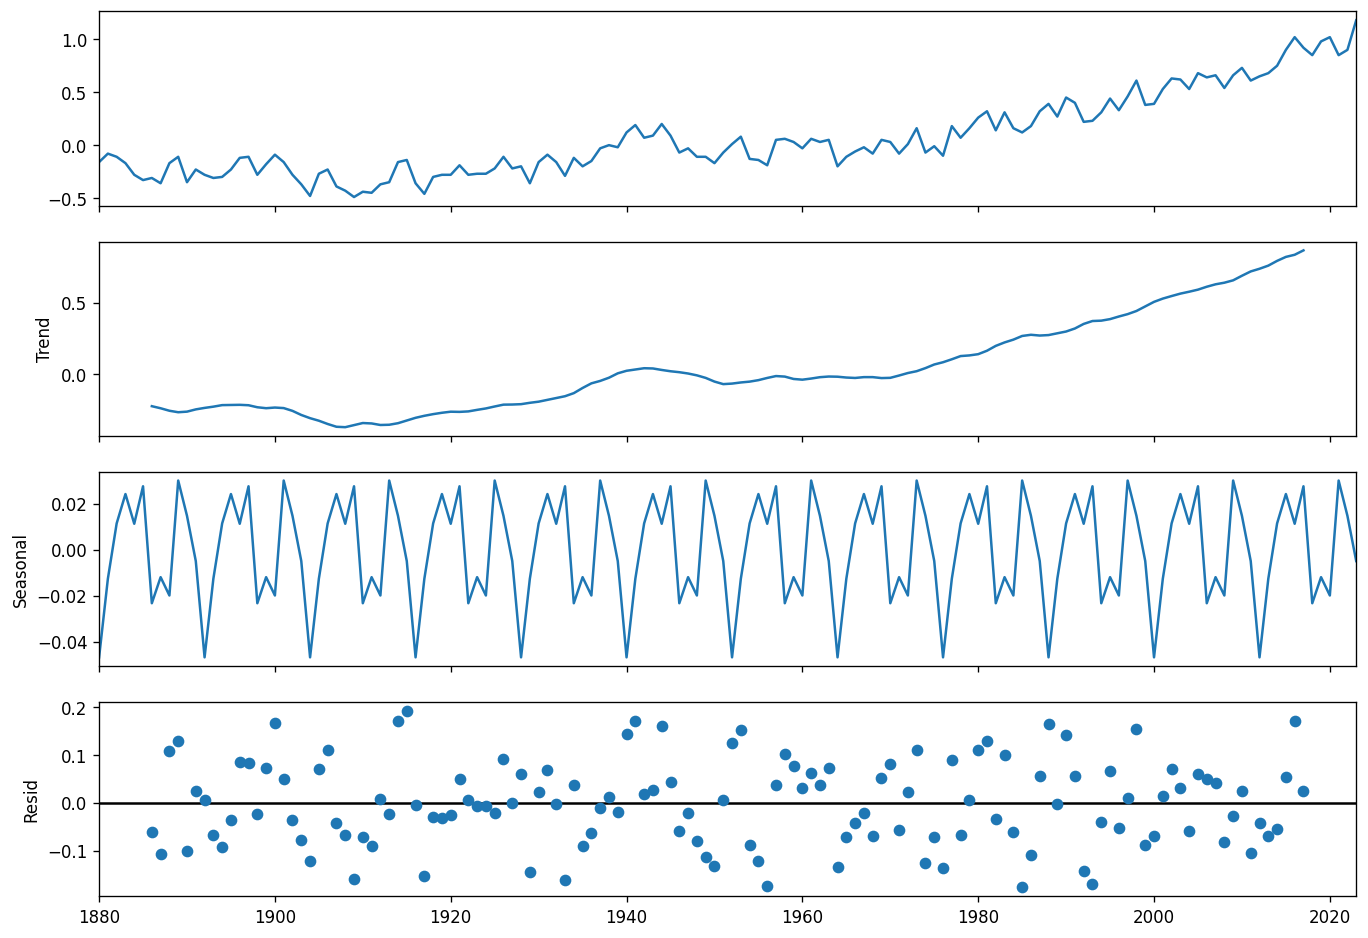

In [53]:
# Decompose the time series
decomposition = sm.tsa.seasonal_decompose(df, model='additive', period=12)
fig = decomposition.plot()
fig.set_size_inches(12, 8)
plt.show()

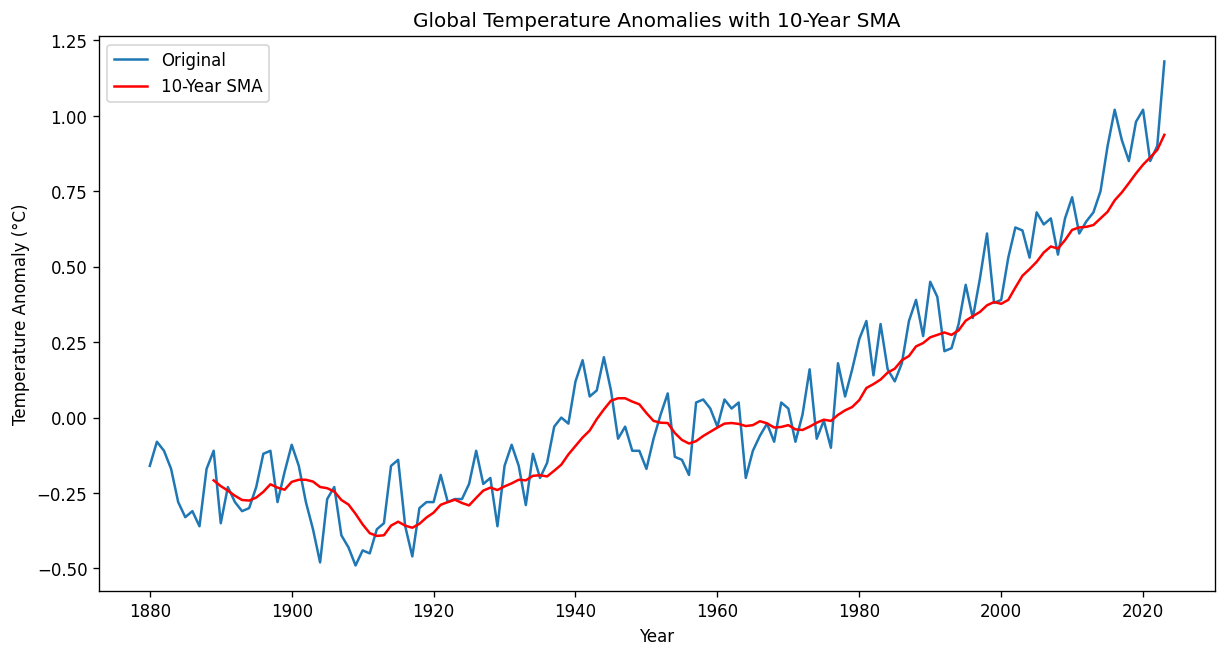

In [54]:
# Apply a simple moving average
df['SMA_10'] = df['Temperature Anomaly'].rolling(window=10).mean()
plt.figure(figsize=(12, 6))
plt.plot(df['Temperature Anomaly'], label='Original')
plt.plot(df['SMA_10'], label='10-Year SMA', color='red')
plt.title('Global Temperature Anomalies with 10-Year SMA')
plt.xlabel('Year')
plt.ylabel('Temperature Anomaly (°C)')
plt.legend()
plt.show()

# Augmented Dickey-Fuller test:

In [55]:
# We can see from the decompisition that there is seasonality, but let's do an ADF test.
result = adfuller(df['Temperature Anomaly'])
print('ADF Statistic: %f' % result[0]) 
print('p-value: %f' % result[1]) 
print('Critical Values:') 
for key, value in result[4].items(): 
    print('\t%s: %.3f' % (key, value))

ADF Statistic: 1.505618
p-value: 0.997545
Critical Values:
	1%: -3.479
	5%: -2.883
	10%: -2.578


We can see the pvalue is greater than 0.05 and therefore the null hypothesis failed to be rejected and the series can be taken as non-stationary or in other words, seasonal.

# Differencing:
We need to make the time series stationary by differencing

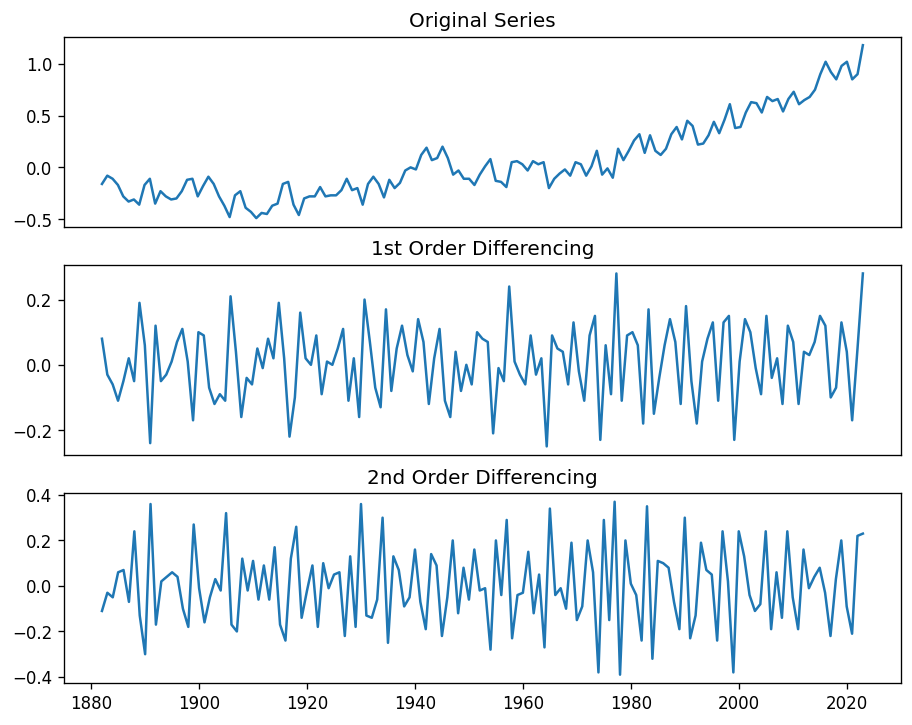

In [56]:
#Creating a function for values 
plt.rcParams.update({'figure.figsize':(9,7), 'figure.dpi':120}) 
# Original Series 
fig, (ax1, ax2, ax3) = plt.subplots(3) 
ax1.plot(df['Temperature Anomaly']); ax1.set_title('Original Series'); ax1.axes.xaxis.set_visible(False) 
# 1st Differencing 
ax2.plot(df['Temperature Anomaly'].diff()); ax2.set_title('1st Order Differencing'); ax2.axes.xaxis.set_visible(False) 
# 2nd Differencing 
ax3.plot(df['Temperature Anomaly'].diff().diff()); ax3.set_title('2nd Order Differencing') 
plt.show()

We can see that after the second differencing there is more noise, so we can select 1st order differencing. Alternatively, we can also again check via Augmented Dickey-Fuller test for stationarity (after dropping any null/NaN values).

In [57]:
#Testing for stationarity after differencing once (using Augmented Dickey-Fuller Test)
result = adfuller(df['Temperature Anomaly'].diff().dropna()) 
print('ADF Statistic: %f' % result[0]) 
print('p-value: %f' % result[1]) 
print('Critical Values:') 
for key, value in result[4].items(): 
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -7.524641
p-value: 0.000000
Critical Values:
	1%: -3.479
	5%: -2.883
	10%: -2.578


We can see that the pvalue is less than 0.05 and therefore the null hypothesis is true and series is now stationary.

# Interpreting ACF and PACF:

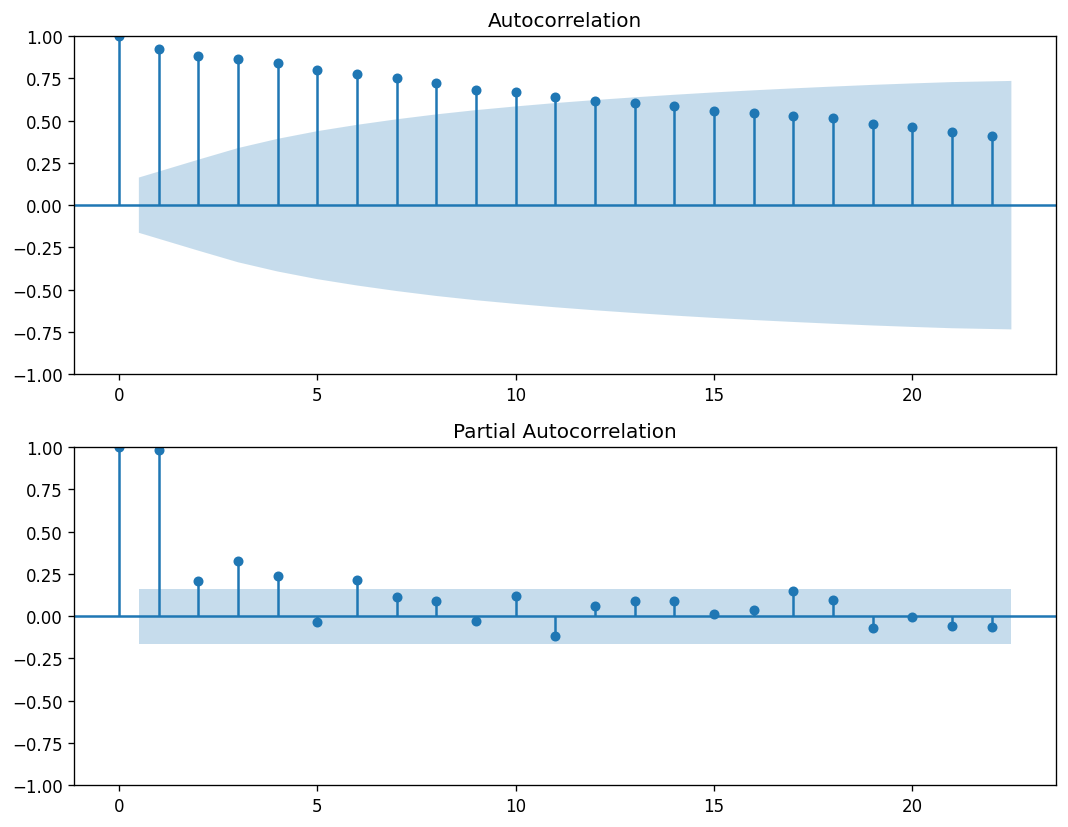

In [58]:
#Plotting ACF and PACF plots
f, ax = plt.subplots(nrows=2, ncols=1)
plot_acf(df['Temperature Anomaly'], ax=ax[0])
plot_pacf(df['Temperature Anomaly'],ax=ax[1], method='ols')
plt.tight_layout()
plt.show()

From the ACF plot, we see a gradual decreasing trend in the lags that indicates than no MA (q) term is required. From the PACF plot, we see an exponential drop after two lags that implies we can have a AR (2) i.e. p=2 model. We could also check through Auto-ARIMA model to see the optimal P, D and Q values.

In [59]:
#Install pamdarima package first and then conduct Auto_ARIMA test
!pip install pmdarima
from pmdarima.arima import auto_arima
test_size=int(0.2*(len(df)))
train, test = (df['Temperature Anomaly']).iloc[:-test_size], (df['Temperature Anomaly']).iloc[-test_size:]
model = auto_arima(train, start_p=1, start_q=1,
                      test='adf',
                      max_p=5, max_q=5,
                      m=1,             
                      d=1,          
                      seasonal=False,   
                      start_P=0, 
                      D=None, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-191.250, Time=0.26 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-175.467, Time=0.04 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-179.150, Time=0.07 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-185.989, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-177.213, Time=0.02 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-190.161, Time=0.23 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-189.927, Time=0.61 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-191.334, Time=0.22 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=-190.397, Time=0.45 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=-194.194, Time=0.64 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=-192.225, Time=0.95 sec
 ARIMA(1,1,4)(0,0,0)[0] intercept   : AIC=-192.227, Time=0.95 sec
 ARIMA(0,1,4)(0,0,0)[0] intercept   : AIC=-190.046, Time=0.80 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-189.430, Time=0.65 sec
 ARIMA(2,1,4)(0,0,0)[0] intercept

# Forecasting:

/opt/conda/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/conda/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/conda/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/conda/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/opt/conda/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

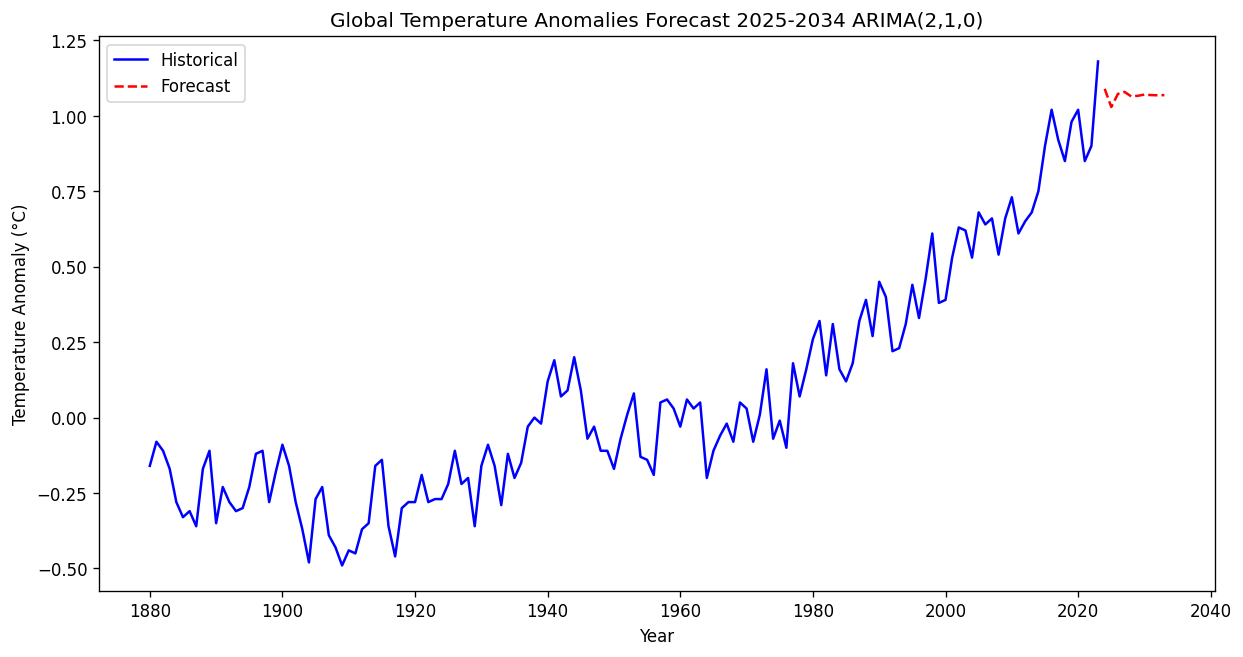

      Forecast
2024  1.089275
2025  1.029000
2026  1.072738
2027  1.079178
2028  1.064198


In [65]:
# Forecast future values using ARIMA model with p=2,d=1,q=0 as self-interpreted
# Fit the ARIMA model
model = ARIMA(df['Temperature Anomaly'], order=(2,1,0))
model_fit = model.fit()

# Forecast the next 10 years
forecast_steps = 10
forecast = model_fit.forecast(steps=forecast_steps)

# Create a new DataFrame for the forecasted years
last_year = df.index[-1]
forecast_years = list(range(last_year + 1, last_year + 1 + forecast_steps))
forecast_df = pd.DataFrame(forecast.values, index=forecast_years, columns=['Forecast'])

# Plot the historical data and the forecast
plt.figure(figsize=(12, 6))
plt.plot(df['Temperature Anomaly'], label='Historical', color='blue')
plt.plot(forecast_df['Forecast'], label='Forecast', color='red', linestyle='dashed')
plt.title('Global Temperature Anomalies Forecast 2025-2034 ARIMA(2,1,0)')
plt.xlabel('Year')
plt.ylabel('Temperature Anomaly (°C)')
plt.legend()
plt.show()

# Display the forecast dataframe
print(forecast_df.head())

/opt/conda/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/conda/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/conda/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/conda/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/opt/conda/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

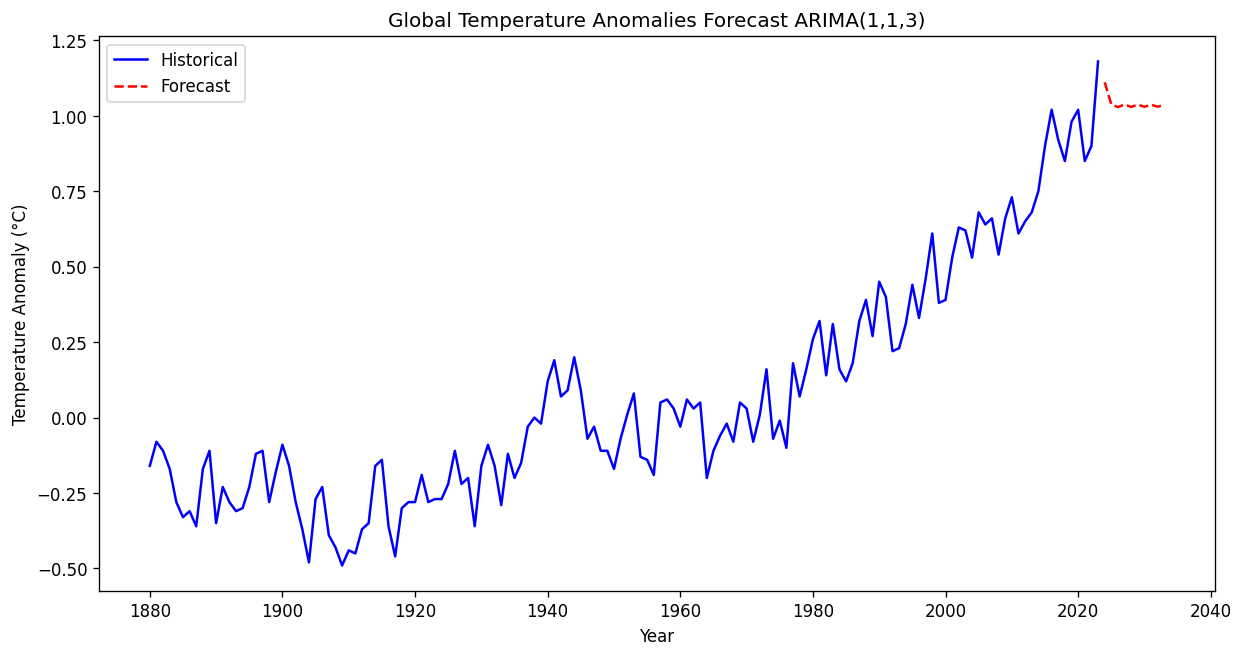

      Forecast
2024  1.110884
2025  1.037936
2026  1.028858
2027  1.037399
2028  1.029363


In [66]:
# Forecast future values using ARIMA model with p=1,d=1,q=3
# Fit the ARIMA model
model = ARIMA(df['Temperature Anomaly'], order=(1,1,3))
model_fit = model.fit()

# Forecast the next 10 years
forecast_steps = 10
forecast = model_fit.forecast(steps=forecast_steps)

# Create a new DataFrame for the forecasted years
last_year = df.index[-1]
forecast_years = list(range(last_year + 1, last_year + 1 + forecast_steps))
forecast_df = pd.DataFrame(forecast.values, index=forecast_years, columns=['Forecast'])

# Plot the historical data and the forecast
plt.figure(figsize=(12, 6))
plt.plot(df['Temperature Anomaly'], label='Historical', color='blue')
plt.plot(forecast_df['Forecast'], label='Forecast', color='red', linestyle='dashed')
plt.title('Global Temperature Anomalies Forecast ARIMA(1,1,3)')
plt.xlabel('Year')
plt.ylabel('Temperature Anomaly (°C)')
plt.legend()
plt.show()

# Display the forecast dataframe
print(forecast_df.head())

We can see that even with both methods: self-interpretation and Auto-ARIMA, the prediction doesn't look correct. So, let's try Seasonal ARIMA forecasting.

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -5.50541D-01    |proj g|=  1.78747D+00


/opt/conda/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/conda/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate    5    f= -5.89051D-01    |proj g|=  4.20150D-02

At iterate   10    f= -5.90970D-01    |proj g|=  4.29841D-04

At iterate   15    f= -5.90970D-01    |proj g|=  5.60761D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     16     23      1     0     0   8.296D-05  -5.910D-01
  F = -0.59097045316925478     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


/opt/conda/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/opt/conda/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


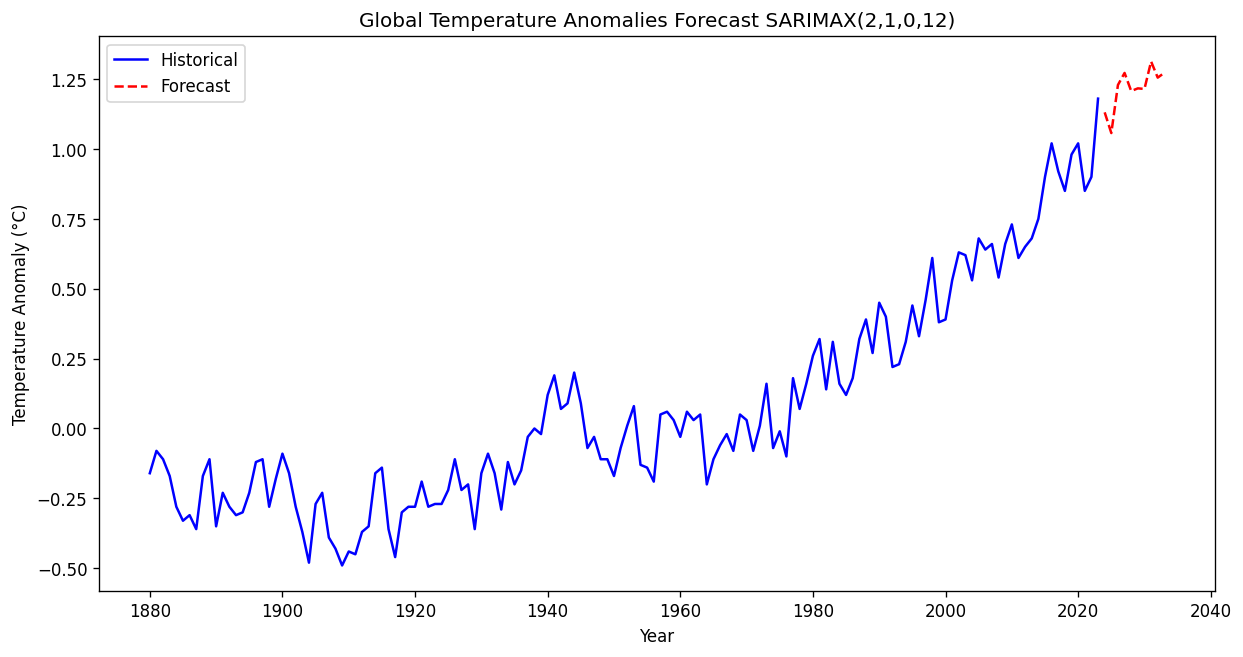

      Forecast
2024  1.130921
2025  1.056842
2026  1.228829
2027  1.271905
2028  1.207179


In [73]:
# Forecast SARIMAX using the self-interpretation co-efficients and seasonality set to 12 (12 months in a year)
model = sm.tsa.statespace.SARIMAX(df['Temperature Anomaly'], order=(2,1,0),seasonal_order=(2,1,0,12))
model_fit = model.fit()

# Forecast the next 10 years
forecast_steps = 10
forecast = model_fit.forecast(steps=forecast_steps)

# Create a new DataFrame for the forecasted years
last_year = df.index[-1]
forecast_years = list(range(last_year + 1, last_year + 1 + forecast_steps))
forecast_df = pd.DataFrame(forecast.values, index=forecast_years, columns=['Forecast'])

# Plot the historical data and the forecast
plt.figure(figsize=(12, 6))
plt.plot(df['Temperature Anomaly'], label='Historical', color='blue')
plt.plot(forecast_df['Forecast'], label='Forecast', color='red', linestyle='dashed')
plt.title('Global Temperature Anomalies Forecast SARIMAX(2,1,0,12)')
plt.xlabel('Year')
plt.ylabel('Temperature Anomaly (°C)')
plt.legend()
plt.show()

# Display the forecast dataframe
print(forecast_df.head())

/opt/conda/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/conda/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/conda/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            9     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -5.33398D-01    |proj g|=  1.34769D+00


 This problem is unconstrained.



At iterate    5    f= -5.84467D-01    |proj g|=  2.24591D+00

At iterate   10    f= -6.61224D-01    |proj g|=  3.69169D-02

At iterate   15    f= -6.62647D-01    |proj g|=  3.88054D-02

At iterate   20    f= -6.63517D-01    |proj g|=  2.45459D-01

At iterate   25    f= -6.67550D-01    |proj g|=  2.19351D-01

At iterate   30    f= -6.68930D-01    |proj g|=  1.53555D-01

At iterate   35    f= -6.69366D-01    |proj g|=  1.49934D-01

At iterate   40    f= -6.70753D-01    |proj g|=  1.45867D-01

At iterate   45    f= -6.70936D-01    |proj g|=  1.73692D-03

At iterate   50    f= -6.71042D-01    |proj g|=  2.32977D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

/opt/conda/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/conda/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/opt/conda/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


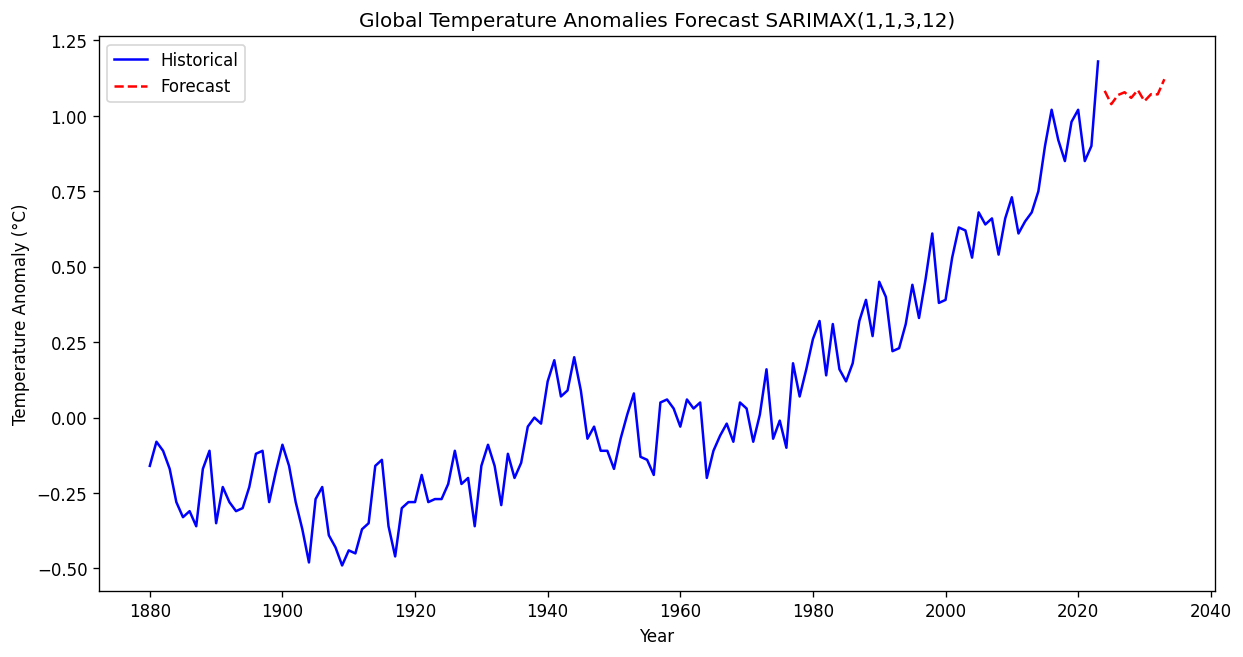

      Forecast
2024  1.082696
2025  1.038630
2026  1.068735
2027  1.077951
2028  1.059409


In [71]:
# Forecast SARIMAX using the self-interpretation co-efficients and seasonality set to 12 (12 months in a year)
model = sm.tsa.statespace.SARIMAX(df['Temperature Anomaly'], order=(1,1,3),seasonal_order=(1,1,3,12))
model_fit = model.fit()

# Forecast the next 10 years
forecast_steps = 10
forecast = model_fit.forecast(steps=forecast_steps)

# Create a new DataFrame for the forecasted years
last_year = df.index[-1]
forecast_years = list(range(last_year + 1, last_year + 1 + forecast_steps))
forecast_df = pd.DataFrame(forecast.values, index=forecast_years, columns=['Forecast'])

# Plot the historical data and the forecast
plt.figure(figsize=(12, 6))
plt.plot(df['Temperature Anomaly'], label='Historical', color='blue')
plt.plot(forecast_df['Forecast'], label='Forecast', color='red', linestyle='dashed')
plt.title('Global Temperature Anomalies Forecast SARIMAX(1,1,3,12)')
plt.xlabel('Year')
plt.ylabel('Temperature Anomaly (°C)')
plt.legend()
plt.show()

# Display the forecast dataframe
print(forecast_df.head())

We can see that there is a slight improvement in the forecasting using SARIMAX. Let's also try to forecast using LSTM model.  

/opt/conda/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_4 (LSTM)                   │ (None, 10, 50)         │        10,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 10, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_5 (LSTM)                   │ (None, 50)             │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 30,651 (119.73 KB)

 Trainable params: 30,651 (119.73 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 4s 159ms/step - loss: 0.0629 - val_loss: 0.2510
Epoch 2/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0240 - val_loss: 0.0582
Epoch 3/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0101 - val_loss: 0.0061
Epoch 4/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0152 - val_loss: 0.0227
Epoch 5/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0088 - val_loss: 0.0621
Epoch 6/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0095 - val_loss: 0.0738
Epoch 7/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0085 - val_loss: 0.0624
Epoch 8/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0075 - val_loss: 0.0345
Epoch 9/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0064 - val_loss: 0.0153
Epoch 10/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0079 - val_loss: 0.0119
Epoch 11/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0077 - val_loss: 0.0186
Epoch 12/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0057 - val_l

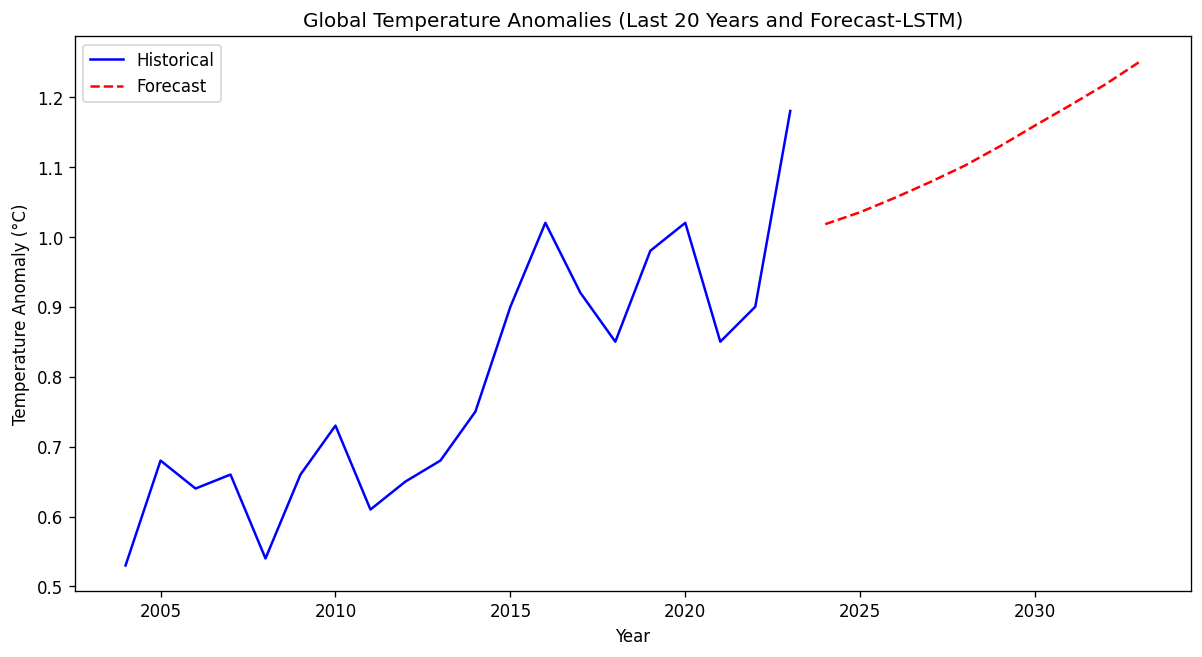

      Forecast
2024  1.018063
2025  1.035203
2026  1.056024
2027  1.078297
2028  1.102099


In [74]:
# Clean and prepare the data
df = df_raw.copy()
df = df.rename(columns=lambda x: x.strip())
df = df[['Year', 'J-D']]
df.columns = ['Year', 'Temperature Anomaly']
df = df[df['Temperature Anomaly'] != '***']
df['Temperature Anomaly'] = df['Temperature Anomaly'].astype(float)
df.set_index('Year', inplace=True)

# Prepare the data for the LSTM model
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(df[['Temperature Anomaly']])

# Create sequences
def create_sequences(data, seq_length):
    xs, ys = [], []
    for i in range(len(data)-seq_length):
        x = data[i:i+seq_length]
        y = data[i+seq_length]
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)

seq_length = 10
X, y = create_sequences(scaled_data, seq_length)

# Reshape input to be 3D [samples, timesteps, features] for LSTM
X = X.reshape((X.shape[0], X.shape[1], 1))

# Split the data into training and testing sets
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Step 2: Build the LSTM model
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(seq_length, 1)))
model.add(Dropout(0.2))
model.add(LSTM(units=50))
model.add(Dropout(0.2))
model.add(Dense(1))

model.compile(optimizer='adam', loss='mean_squared_error')
model.summary()

# Step 3: Train the model
history = model.fit(X_train, y_train, epochs=100, batch_size=32, validation_data=(X_test, y_test))

# Step 4: Make predictions
# Forecast for the next 10 years
forecast_steps = 10
forecast = []

# Start with the last observed sequence
last_sequence = X[-1]

for _ in range(forecast_steps):
    next_value = model.predict(last_sequence[np.newaxis, :, :])[0, 0]
    forecast.append(next_value)
    # Update the last sequence by removing the first value and adding the new prediction
    last_sequence = np.append(last_sequence[1:], next_value).reshape((seq_length, 1))

# Inverse transform the forecast to the original scale
forecast = scaler.inverse_transform(np.array(forecast).reshape(-1, 1)).flatten()

# Create a DataFrame for the forecasted years
last_year = df.index[-1]
forecast_years = list(range(last_year + 1, last_year + 1 + forecast_steps))
forecast_df = pd.DataFrame(forecast, index=forecast_years, columns=['Forecast'])

# Combine the last 20 years of historical data with the forecast
historical_last_20_years = df.iloc[-20:]

# Plot the historical data (last 20 years) and the forecast
plt.figure(figsize=(12, 6))
plt.plot(historical_last_20_years['Temperature Anomaly'], label='Historical', color='blue')
plt.plot(forecast_df['Forecast'], label='Forecast', color='red', linestyle='dashed')
plt.title('Global Temperature Anomalies (Last 20 Years and Forecast-LSTM)')
plt.xlabel('Year')
plt.ylabel('Temperature Anomaly (°C)')
plt.legend()
plt.show()

# Display the forecast dataframe
print(forecast_df.head())

We can see that the LSTM model doesn't perform that well and is not particularly suited for this forecast.